### Урок 3. Generative adversarial networks (GAN): генеративные сети#

### -- Автор: Шенк Евгений Станиславович

In [1]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Задание 1. 
Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            #nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [4]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [6]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [7]:
class Lesson_4_Dataset(Dataset):
    def __init__(self, data,  transform=None):
        self.data = data
        self.transform=transform

    def __len__(self):
        if self.transform is not None:
            return len(self.transform)
        else:
            return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx,:-1]
        if self.transform is not None:
            pass
            
        label = self.data.iloc[idx,-1]

        return (item.to_numpy(), label) 

### Train

In [8]:
n_epochs = 500
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 2
img_size = 2
channels = 1

sample_interval = 25

img_shape = (channels, img_size)

функция $y = \frac{sin(x)}{x} - \frac{x}{10}$

In [9]:
def func_y(x):
    return np.sin(x)/x - x/10

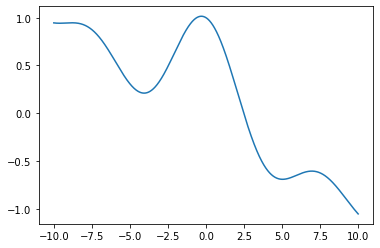

In [10]:
np.random.seed(2177)
X_train = np.sort(np.random.uniform(-10,10, 12800))
y_train = func_y(X_train)
data = pd.DataFrame({'X': X_train, 'y': y_train, 'label': 1})

plt.plot(X_train, y_train)

In [11]:
real_data = torch.utils.data.DataLoader(
    Lesson_4_Dataset(data),
    batch_size=batch_size,
    shuffle=True,
)

In [12]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [13]:
d_loss_history = []
g_loss_history = []
gen_imgs_results = []

In [14]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, (data_value, labels) in enumerate(real_data):

        batch_size = data_value.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(data_value.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

    if epoch in [10, 25, 50, 100, 200, 300, 400, 499]:
        result = gen_imgs[:,0].cpu()
        result = result.detach().numpy()
        result = result[result[:,0].argsort()]
        gen_imgs_results.append(result)

[Epoch 0/500] [Batch 0/200] [D loss: 0.693146] [G loss: 0.695074]
[Epoch 0/500] [Batch 25/200] [D loss: 0.681904] [G loss: 0.671216]
[Epoch 0/500] [Batch 50/200] [D loss: 0.692652] [G loss: 0.705970]
[Epoch 0/500] [Batch 75/200] [D loss: 0.691734] [G loss: 0.724050]
[Epoch 0/500] [Batch 100/200] [D loss: 0.693405] [G loss: 0.697145]
[Epoch 0/500] [Batch 125/200] [D loss: 0.687756] [G loss: 0.685380]
[Epoch 0/500] [Batch 150/200] [D loss: 0.692557] [G loss: 0.713091]
[Epoch 0/500] [Batch 175/200] [D loss: 0.693203] [G loss: 0.698826]
[Epoch 1/500] [Batch 0/200] [D loss: 0.694230] [G loss: 0.700625]
[Epoch 1/500] [Batch 25/200] [D loss: 0.693215] [G loss: 0.696864]
[Epoch 1/500] [Batch 50/200] [D loss: 0.692852] [G loss: 0.696117]
[Epoch 1/500] [Batch 75/200] [D loss: 0.692240] [G loss: 0.695408]
[Epoch 1/500] [Batch 100/200] [D loss: 0.691535] [G loss: 0.681000]
[Epoch 1/500] [Batch 125/200] [D loss: 0.696419] [G loss: 0.702806]
[Epoch 1/500] [Batch 150/200] [D loss: 0.689903] [G loss: 

[Epoch 15/500] [Batch 50/200] [D loss: 0.691419] [G loss: 0.692310]
[Epoch 15/500] [Batch 75/200] [D loss: 0.692052] [G loss: 0.693329]
[Epoch 15/500] [Batch 100/200] [D loss: 0.692106] [G loss: 0.695403]
[Epoch 15/500] [Batch 125/200] [D loss: 0.690830] [G loss: 0.696424]
[Epoch 15/500] [Batch 150/200] [D loss: 0.692506] [G loss: 0.695453]
[Epoch 15/500] [Batch 175/200] [D loss: 0.689835] [G loss: 0.696981]
[Epoch 16/500] [Batch 0/200] [D loss: 0.693193] [G loss: 0.693615]
[Epoch 16/500] [Batch 25/200] [D loss: 0.694159] [G loss: 0.690590]
[Epoch 16/500] [Batch 50/200] [D loss: 0.694525] [G loss: 0.703823]
[Epoch 16/500] [Batch 75/200] [D loss: 0.692265] [G loss: 0.702033]
[Epoch 16/500] [Batch 100/200] [D loss: 0.690730] [G loss: 0.699661]
[Epoch 16/500] [Batch 125/200] [D loss: 0.692242] [G loss: 0.695991]
[Epoch 16/500] [Batch 150/200] [D loss: 0.691174] [G loss: 0.684335]
[Epoch 16/500] [Batch 175/200] [D loss: 0.691946] [G loss: 0.695366]
[Epoch 17/500] [Batch 0/200] [D loss: 0.6

[Epoch 30/500] [Batch 50/200] [D loss: 0.689780] [G loss: 0.708665]
[Epoch 30/500] [Batch 75/200] [D loss: 0.695135] [G loss: 0.683765]
[Epoch 30/500] [Batch 100/200] [D loss: 0.694115] [G loss: 0.701767]
[Epoch 30/500] [Batch 125/200] [D loss: 0.697415] [G loss: 0.707754]
[Epoch 30/500] [Batch 150/200] [D loss: 0.697967] [G loss: 0.707051]
[Epoch 30/500] [Batch 175/200] [D loss: 0.686840] [G loss: 0.705147]
[Epoch 31/500] [Batch 0/200] [D loss: 0.688116] [G loss: 0.695045]
[Epoch 31/500] [Batch 25/200] [D loss: 0.689306] [G loss: 0.693350]
[Epoch 31/500] [Batch 50/200] [D loss: 0.689139] [G loss: 0.690286]
[Epoch 31/500] [Batch 75/200] [D loss: 0.688956] [G loss: 0.695072]
[Epoch 31/500] [Batch 100/200] [D loss: 0.691095] [G loss: 0.686138]
[Epoch 31/500] [Batch 125/200] [D loss: 0.693819] [G loss: 0.681856]
[Epoch 31/500] [Batch 150/200] [D loss: 0.690468] [G loss: 0.693280]
[Epoch 31/500] [Batch 175/200] [D loss: 0.687897] [G loss: 0.698050]
[Epoch 32/500] [Batch 0/200] [D loss: 0.6

[Epoch 45/500] [Batch 50/200] [D loss: 0.686851] [G loss: 0.696037]
[Epoch 45/500] [Batch 75/200] [D loss: 0.689440] [G loss: 0.686648]
[Epoch 45/500] [Batch 100/200] [D loss: 0.698207] [G loss: 0.708727]
[Epoch 45/500] [Batch 125/200] [D loss: 0.679266] [G loss: 0.699124]
[Epoch 45/500] [Batch 150/200] [D loss: 0.680405] [G loss: 0.707475]
[Epoch 45/500] [Batch 175/200] [D loss: 0.690051] [G loss: 0.688519]
[Epoch 46/500] [Batch 0/200] [D loss: 0.690388] [G loss: 0.681325]
[Epoch 46/500] [Batch 25/200] [D loss: 0.689986] [G loss: 0.676994]
[Epoch 46/500] [Batch 50/200] [D loss: 0.685473] [G loss: 0.716526]
[Epoch 46/500] [Batch 75/200] [D loss: 0.688326] [G loss: 0.690845]
[Epoch 46/500] [Batch 100/200] [D loss: 0.687073] [G loss: 0.677247]
[Epoch 46/500] [Batch 125/200] [D loss: 0.691513] [G loss: 0.696869]
[Epoch 46/500] [Batch 150/200] [D loss: 0.693794] [G loss: 0.680074]
[Epoch 46/500] [Batch 175/200] [D loss: 0.686570] [G loss: 0.705035]
[Epoch 47/500] [Batch 0/200] [D loss: 0.6

[Epoch 60/500] [Batch 50/200] [D loss: 0.678307] [G loss: 0.712475]
[Epoch 60/500] [Batch 75/200] [D loss: 0.680589] [G loss: 0.714992]
[Epoch 60/500] [Batch 100/200] [D loss: 0.682671] [G loss: 0.736826]
[Epoch 60/500] [Batch 125/200] [D loss: 0.691593] [G loss: 0.677722]
[Epoch 60/500] [Batch 150/200] [D loss: 0.688267] [G loss: 0.705682]
[Epoch 60/500] [Batch 175/200] [D loss: 0.682263] [G loss: 0.697561]
[Epoch 61/500] [Batch 0/200] [D loss: 0.695741] [G loss: 0.682849]
[Epoch 61/500] [Batch 25/200] [D loss: 0.688147] [G loss: 0.714068]
[Epoch 61/500] [Batch 50/200] [D loss: 0.687723] [G loss: 0.690371]
[Epoch 61/500] [Batch 75/200] [D loss: 0.682539] [G loss: 0.694598]
[Epoch 61/500] [Batch 100/200] [D loss: 0.693914] [G loss: 0.692481]
[Epoch 61/500] [Batch 125/200] [D loss: 0.691363] [G loss: 0.687897]
[Epoch 61/500] [Batch 150/200] [D loss: 0.686763] [G loss: 0.686880]
[Epoch 61/500] [Batch 175/200] [D loss: 0.686997] [G loss: 0.698473]
[Epoch 62/500] [Batch 0/200] [D loss: 0.6

[Epoch 75/500] [Batch 50/200] [D loss: 0.684367] [G loss: 0.711145]
[Epoch 75/500] [Batch 75/200] [D loss: 0.668534] [G loss: 0.714461]
[Epoch 75/500] [Batch 100/200] [D loss: 0.688232] [G loss: 0.697057]
[Epoch 75/500] [Batch 125/200] [D loss: 0.689265] [G loss: 0.686516]
[Epoch 75/500] [Batch 150/200] [D loss: 0.685575] [G loss: 0.716118]
[Epoch 75/500] [Batch 175/200] [D loss: 0.705624] [G loss: 0.713790]
[Epoch 76/500] [Batch 0/200] [D loss: 0.692569] [G loss: 0.691532]
[Epoch 76/500] [Batch 25/200] [D loss: 0.682250] [G loss: 0.697371]
[Epoch 76/500] [Batch 50/200] [D loss: 0.685933] [G loss: 0.701606]
[Epoch 76/500] [Batch 75/200] [D loss: 0.677651] [G loss: 0.698875]
[Epoch 76/500] [Batch 100/200] [D loss: 0.690260] [G loss: 0.715730]
[Epoch 76/500] [Batch 125/200] [D loss: 0.671405] [G loss: 0.722812]
[Epoch 76/500] [Batch 150/200] [D loss: 0.687847] [G loss: 0.684137]
[Epoch 76/500] [Batch 175/200] [D loss: 0.679187] [G loss: 0.687711]
[Epoch 77/500] [Batch 0/200] [D loss: 0.6

[Epoch 90/500] [Batch 50/200] [D loss: 0.675961] [G loss: 0.722135]
[Epoch 90/500] [Batch 75/200] [D loss: 0.684181] [G loss: 0.712697]
[Epoch 90/500] [Batch 100/200] [D loss: 0.698595] [G loss: 0.706987]
[Epoch 90/500] [Batch 125/200] [D loss: 0.679761] [G loss: 0.702584]
[Epoch 90/500] [Batch 150/200] [D loss: 0.683449] [G loss: 0.709675]
[Epoch 90/500] [Batch 175/200] [D loss: 0.689108] [G loss: 0.688964]
[Epoch 91/500] [Batch 0/200] [D loss: 0.682485] [G loss: 0.685051]
[Epoch 91/500] [Batch 25/200] [D loss: 0.685416] [G loss: 0.685780]
[Epoch 91/500] [Batch 50/200] [D loss: 0.686377] [G loss: 0.688534]
[Epoch 91/500] [Batch 75/200] [D loss: 0.677409] [G loss: 0.742343]
[Epoch 91/500] [Batch 100/200] [D loss: 0.677793] [G loss: 0.725875]
[Epoch 91/500] [Batch 125/200] [D loss: 0.675615] [G loss: 0.711238]
[Epoch 91/500] [Batch 150/200] [D loss: 0.675187] [G loss: 0.736088]
[Epoch 91/500] [Batch 175/200] [D loss: 0.690729] [G loss: 0.702108]
[Epoch 92/500] [Batch 0/200] [D loss: 0.6

[Epoch 105/500] [Batch 50/200] [D loss: 0.687625] [G loss: 0.713088]
[Epoch 105/500] [Batch 75/200] [D loss: 0.681210] [G loss: 0.712581]
[Epoch 105/500] [Batch 100/200] [D loss: 0.676973] [G loss: 0.710918]
[Epoch 105/500] [Batch 125/200] [D loss: 0.679644] [G loss: 0.703412]
[Epoch 105/500] [Batch 150/200] [D loss: 0.687687] [G loss: 0.704551]
[Epoch 105/500] [Batch 175/200] [D loss: 0.678127] [G loss: 0.738966]
[Epoch 106/500] [Batch 0/200] [D loss: 0.670206] [G loss: 0.696359]
[Epoch 106/500] [Batch 25/200] [D loss: 0.685331] [G loss: 0.698005]
[Epoch 106/500] [Batch 50/200] [D loss: 0.690754] [G loss: 0.722754]
[Epoch 106/500] [Batch 75/200] [D loss: 0.682211] [G loss: 0.702615]
[Epoch 106/500] [Batch 100/200] [D loss: 0.702319] [G loss: 0.660938]
[Epoch 106/500] [Batch 125/200] [D loss: 0.683896] [G loss: 0.698132]
[Epoch 106/500] [Batch 150/200] [D loss: 0.689366] [G loss: 0.711287]
[Epoch 106/500] [Batch 175/200] [D loss: 0.690948] [G loss: 0.683152]
[Epoch 107/500] [Batch 0/20

[Epoch 120/500] [Batch 25/200] [D loss: 0.676293] [G loss: 0.711889]
[Epoch 120/500] [Batch 50/200] [D loss: 0.687789] [G loss: 0.680235]
[Epoch 120/500] [Batch 75/200] [D loss: 0.670970] [G loss: 0.734547]
[Epoch 120/500] [Batch 100/200] [D loss: 0.680603] [G loss: 0.718413]
[Epoch 120/500] [Batch 125/200] [D loss: 0.684290] [G loss: 0.733716]
[Epoch 120/500] [Batch 150/200] [D loss: 0.677745] [G loss: 0.702279]
[Epoch 120/500] [Batch 175/200] [D loss: 0.687613] [G loss: 0.676353]
[Epoch 121/500] [Batch 0/200] [D loss: 0.684817] [G loss: 0.676509]
[Epoch 121/500] [Batch 25/200] [D loss: 0.682457] [G loss: 0.714501]
[Epoch 121/500] [Batch 50/200] [D loss: 0.688652] [G loss: 0.729251]
[Epoch 121/500] [Batch 75/200] [D loss: 0.688198] [G loss: 0.696241]
[Epoch 121/500] [Batch 100/200] [D loss: 0.661601] [G loss: 0.741613]
[Epoch 121/500] [Batch 125/200] [D loss: 0.688860] [G loss: 0.693447]
[Epoch 121/500] [Batch 150/200] [D loss: 0.687445] [G loss: 0.688435]
[Epoch 121/500] [Batch 175/2

[Epoch 135/500] [Batch 0/200] [D loss: 0.678947] [G loss: 0.720004]
[Epoch 135/500] [Batch 25/200] [D loss: 0.693342] [G loss: 0.704985]
[Epoch 135/500] [Batch 50/200] [D loss: 0.684549] [G loss: 0.706743]
[Epoch 135/500] [Batch 75/200] [D loss: 0.689382] [G loss: 0.673785]
[Epoch 135/500] [Batch 100/200] [D loss: 0.688100] [G loss: 0.686412]
[Epoch 135/500] [Batch 125/200] [D loss: 0.673850] [G loss: 0.695574]
[Epoch 135/500] [Batch 150/200] [D loss: 0.679391] [G loss: 0.681273]
[Epoch 135/500] [Batch 175/200] [D loss: 0.688454] [G loss: 0.738862]
[Epoch 136/500] [Batch 0/200] [D loss: 0.680894] [G loss: 0.697166]
[Epoch 136/500] [Batch 25/200] [D loss: 0.679671] [G loss: 0.744347]
[Epoch 136/500] [Batch 50/200] [D loss: 0.685791] [G loss: 0.692465]
[Epoch 136/500] [Batch 75/200] [D loss: 0.688439] [G loss: 0.687818]
[Epoch 136/500] [Batch 100/200] [D loss: 0.689290] [G loss: 0.682363]
[Epoch 136/500] [Batch 125/200] [D loss: 0.684158] [G loss: 0.700770]
[Epoch 136/500] [Batch 150/200

[Epoch 149/500] [Batch 175/200] [D loss: 0.699650] [G loss: 0.649420]
[Epoch 150/500] [Batch 0/200] [D loss: 0.685920] [G loss: 0.692329]
[Epoch 150/500] [Batch 25/200] [D loss: 0.672750] [G loss: 0.740566]
[Epoch 150/500] [Batch 50/200] [D loss: 0.694927] [G loss: 0.688486]
[Epoch 150/500] [Batch 75/200] [D loss: 0.677859] [G loss: 0.703672]
[Epoch 150/500] [Batch 100/200] [D loss: 0.675978] [G loss: 0.736290]
[Epoch 150/500] [Batch 125/200] [D loss: 0.685265] [G loss: 0.704597]
[Epoch 150/500] [Batch 150/200] [D loss: 0.667884] [G loss: 0.772403]
[Epoch 150/500] [Batch 175/200] [D loss: 0.666826] [G loss: 0.734521]
[Epoch 151/500] [Batch 0/200] [D loss: 0.679550] [G loss: 0.680909]
[Epoch 151/500] [Batch 25/200] [D loss: 0.670737] [G loss: 0.724278]
[Epoch 151/500] [Batch 50/200] [D loss: 0.678841] [G loss: 0.710768]
[Epoch 151/500] [Batch 75/200] [D loss: 0.674674] [G loss: 0.703627]
[Epoch 151/500] [Batch 100/200] [D loss: 0.682969] [G loss: 0.692665]
[Epoch 151/500] [Batch 125/200

[Epoch 164/500] [Batch 150/200] [D loss: 0.686312] [G loss: 0.697898]
[Epoch 164/500] [Batch 175/200] [D loss: 0.688057] [G loss: 0.677360]
[Epoch 165/500] [Batch 0/200] [D loss: 0.692711] [G loss: 0.685498]
[Epoch 165/500] [Batch 25/200] [D loss: 0.688933] [G loss: 0.680040]
[Epoch 165/500] [Batch 50/200] [D loss: 0.688609] [G loss: 0.746971]
[Epoch 165/500] [Batch 75/200] [D loss: 0.682756] [G loss: 0.711659]
[Epoch 165/500] [Batch 100/200] [D loss: 0.679951] [G loss: 0.705303]
[Epoch 165/500] [Batch 125/200] [D loss: 0.682854] [G loss: 0.716788]
[Epoch 165/500] [Batch 150/200] [D loss: 0.669429] [G loss: 0.751299]
[Epoch 165/500] [Batch 175/200] [D loss: 0.683617] [G loss: 0.716733]
[Epoch 166/500] [Batch 0/200] [D loss: 0.686652] [G loss: 0.688813]
[Epoch 166/500] [Batch 25/200] [D loss: 0.684284] [G loss: 0.725209]
[Epoch 166/500] [Batch 50/200] [D loss: 0.679236] [G loss: 0.717380]
[Epoch 166/500] [Batch 75/200] [D loss: 0.680048] [G loss: 0.717355]
[Epoch 166/500] [Batch 100/200

[Epoch 179/500] [Batch 125/200] [D loss: 0.683439] [G loss: 0.684622]
[Epoch 179/500] [Batch 150/200] [D loss: 0.670006] [G loss: 0.712225]
[Epoch 179/500] [Batch 175/200] [D loss: 0.681927] [G loss: 0.700781]
[Epoch 180/500] [Batch 0/200] [D loss: 0.695509] [G loss: 0.669762]
[Epoch 180/500] [Batch 25/200] [D loss: 0.680907] [G loss: 0.712692]
[Epoch 180/500] [Batch 50/200] [D loss: 0.675403] [G loss: 0.723338]
[Epoch 180/500] [Batch 75/200] [D loss: 0.681507] [G loss: 0.723884]
[Epoch 180/500] [Batch 100/200] [D loss: 0.680487] [G loss: 0.720402]
[Epoch 180/500] [Batch 125/200] [D loss: 0.682999] [G loss: 0.711396]
[Epoch 180/500] [Batch 150/200] [D loss: 0.676969] [G loss: 0.685357]
[Epoch 180/500] [Batch 175/200] [D loss: 0.687522] [G loss: 0.699446]
[Epoch 181/500] [Batch 0/200] [D loss: 0.673968] [G loss: 0.710920]
[Epoch 181/500] [Batch 25/200] [D loss: 0.673732] [G loss: 0.681834]
[Epoch 181/500] [Batch 50/200] [D loss: 0.673730] [G loss: 0.714497]
[Epoch 181/500] [Batch 75/200

[Epoch 194/500] [Batch 100/200] [D loss: 0.692026] [G loss: 0.676506]
[Epoch 194/500] [Batch 125/200] [D loss: 0.679357] [G loss: 0.721099]
[Epoch 194/500] [Batch 150/200] [D loss: 0.699003] [G loss: 0.727176]
[Epoch 194/500] [Batch 175/200] [D loss: 0.669881] [G loss: 0.742448]
[Epoch 195/500] [Batch 0/200] [D loss: 0.677357] [G loss: 0.686583]
[Epoch 195/500] [Batch 25/200] [D loss: 0.671682] [G loss: 0.701675]
[Epoch 195/500] [Batch 50/200] [D loss: 0.685878] [G loss: 0.687263]
[Epoch 195/500] [Batch 75/200] [D loss: 0.687797] [G loss: 0.705198]
[Epoch 195/500] [Batch 100/200] [D loss: 0.683384] [G loss: 0.696303]
[Epoch 195/500] [Batch 125/200] [D loss: 0.683214] [G loss: 0.723799]
[Epoch 195/500] [Batch 150/200] [D loss: 0.658640] [G loss: 0.752275]
[Epoch 195/500] [Batch 175/200] [D loss: 0.679073] [G loss: 0.745939]
[Epoch 196/500] [Batch 0/200] [D loss: 0.676817] [G loss: 0.711209]
[Epoch 196/500] [Batch 25/200] [D loss: 0.677070] [G loss: 0.710138]
[Epoch 196/500] [Batch 50/20

[Epoch 209/500] [Batch 75/200] [D loss: 0.682420] [G loss: 0.764665]
[Epoch 209/500] [Batch 100/200] [D loss: 0.671770] [G loss: 0.769810]
[Epoch 209/500] [Batch 125/200] [D loss: 0.682112] [G loss: 0.726882]
[Epoch 209/500] [Batch 150/200] [D loss: 0.680571] [G loss: 0.714141]
[Epoch 209/500] [Batch 175/200] [D loss: 0.679887] [G loss: 0.690574]
[Epoch 210/500] [Batch 0/200] [D loss: 0.695066] [G loss: 0.714976]
[Epoch 210/500] [Batch 25/200] [D loss: 0.681111] [G loss: 0.713782]
[Epoch 210/500] [Batch 50/200] [D loss: 0.695321] [G loss: 0.698698]
[Epoch 210/500] [Batch 75/200] [D loss: 0.678256] [G loss: 0.723102]
[Epoch 210/500] [Batch 100/200] [D loss: 0.703676] [G loss: 0.703320]
[Epoch 210/500] [Batch 125/200] [D loss: 0.685299] [G loss: 0.706329]
[Epoch 210/500] [Batch 150/200] [D loss: 0.691700] [G loss: 0.693590]
[Epoch 210/500] [Batch 175/200] [D loss: 0.674353] [G loss: 0.746898]
[Epoch 211/500] [Batch 0/200] [D loss: 0.696361] [G loss: 0.702472]
[Epoch 211/500] [Batch 25/20

[Epoch 224/500] [Batch 50/200] [D loss: 0.694152] [G loss: 0.721063]
[Epoch 224/500] [Batch 75/200] [D loss: 0.672337] [G loss: 0.747823]
[Epoch 224/500] [Batch 100/200] [D loss: 0.668578] [G loss: 0.726976]
[Epoch 224/500] [Batch 125/200] [D loss: 0.670464] [G loss: 0.735556]
[Epoch 224/500] [Batch 150/200] [D loss: 0.683326] [G loss: 0.724290]
[Epoch 224/500] [Batch 175/200] [D loss: 0.698739] [G loss: 0.699044]
[Epoch 225/500] [Batch 0/200] [D loss: 0.675764] [G loss: 0.697833]
[Epoch 225/500] [Batch 25/200] [D loss: 0.677223] [G loss: 0.695812]
[Epoch 225/500] [Batch 50/200] [D loss: 0.674324] [G loss: 0.733810]
[Epoch 225/500] [Batch 75/200] [D loss: 0.689529] [G loss: 0.698959]
[Epoch 225/500] [Batch 100/200] [D loss: 0.685849] [G loss: 0.717232]
[Epoch 225/500] [Batch 125/200] [D loss: 0.681164] [G loss: 0.701950]
[Epoch 225/500] [Batch 150/200] [D loss: 0.659569] [G loss: 0.754025]
[Epoch 225/500] [Batch 175/200] [D loss: 0.679616] [G loss: 0.701621]
[Epoch 226/500] [Batch 0/20

[Epoch 239/500] [Batch 25/200] [D loss: 0.665282] [G loss: 0.725258]
[Epoch 239/500] [Batch 50/200] [D loss: 0.679947] [G loss: 0.688576]
[Epoch 239/500] [Batch 75/200] [D loss: 0.678785] [G loss: 0.714432]
[Epoch 239/500] [Batch 100/200] [D loss: 0.694743] [G loss: 0.713539]
[Epoch 239/500] [Batch 125/200] [D loss: 0.680017] [G loss: 0.755134]
[Epoch 239/500] [Batch 150/200] [D loss: 0.677809] [G loss: 0.686057]
[Epoch 239/500] [Batch 175/200] [D loss: 0.696462] [G loss: 0.729750]
[Epoch 240/500] [Batch 0/200] [D loss: 0.692150] [G loss: 0.722168]
[Epoch 240/500] [Batch 25/200] [D loss: 0.696273] [G loss: 0.679650]
[Epoch 240/500] [Batch 50/200] [D loss: 0.678004] [G loss: 0.693736]
[Epoch 240/500] [Batch 75/200] [D loss: 0.673059] [G loss: 0.747695]
[Epoch 240/500] [Batch 100/200] [D loss: 0.687554] [G loss: 0.716502]
[Epoch 240/500] [Batch 125/200] [D loss: 0.659690] [G loss: 0.777787]
[Epoch 240/500] [Batch 150/200] [D loss: 0.661642] [G loss: 0.738321]
[Epoch 240/500] [Batch 175/2

[Epoch 254/500] [Batch 0/200] [D loss: 0.674335] [G loss: 0.725677]
[Epoch 254/500] [Batch 25/200] [D loss: 0.698387] [G loss: 0.726665]
[Epoch 254/500] [Batch 50/200] [D loss: 0.672159] [G loss: 0.723828]
[Epoch 254/500] [Batch 75/200] [D loss: 0.672390] [G loss: 0.788367]
[Epoch 254/500] [Batch 100/200] [D loss: 0.687620] [G loss: 0.709326]
[Epoch 254/500] [Batch 125/200] [D loss: 0.680292] [G loss: 0.716330]
[Epoch 254/500] [Batch 150/200] [D loss: 0.669055] [G loss: 0.744657]
[Epoch 254/500] [Batch 175/200] [D loss: 0.677234] [G loss: 0.705703]
[Epoch 255/500] [Batch 0/200] [D loss: 0.663278] [G loss: 0.741085]
[Epoch 255/500] [Batch 25/200] [D loss: 0.674559] [G loss: 0.764024]
[Epoch 255/500] [Batch 50/200] [D loss: 0.686561] [G loss: 0.697521]
[Epoch 255/500] [Batch 75/200] [D loss: 0.672432] [G loss: 0.712542]
[Epoch 255/500] [Batch 100/200] [D loss: 0.693772] [G loss: 0.733888]
[Epoch 255/500] [Batch 125/200] [D loss: 0.663822] [G loss: 0.796555]
[Epoch 255/500] [Batch 150/200

[Epoch 268/500] [Batch 175/200] [D loss: 0.685469] [G loss: 0.689873]
[Epoch 269/500] [Batch 0/200] [D loss: 0.675650] [G loss: 0.722513]
[Epoch 269/500] [Batch 25/200] [D loss: 0.689833] [G loss: 0.680122]
[Epoch 269/500] [Batch 50/200] [D loss: 0.693469] [G loss: 0.699490]
[Epoch 269/500] [Batch 75/200] [D loss: 0.697350] [G loss: 0.658585]
[Epoch 269/500] [Batch 100/200] [D loss: 0.692768] [G loss: 0.673285]
[Epoch 269/500] [Batch 125/200] [D loss: 0.682234] [G loss: 0.693546]
[Epoch 269/500] [Batch 150/200] [D loss: 0.694162] [G loss: 0.737814]
[Epoch 269/500] [Batch 175/200] [D loss: 0.677021] [G loss: 0.720497]
[Epoch 270/500] [Batch 0/200] [D loss: 0.675475] [G loss: 0.727632]
[Epoch 270/500] [Batch 25/200] [D loss: 0.671577] [G loss: 0.784007]
[Epoch 270/500] [Batch 50/200] [D loss: 0.678588] [G loss: 0.703715]
[Epoch 270/500] [Batch 75/200] [D loss: 0.692851] [G loss: 0.708475]
[Epoch 270/500] [Batch 100/200] [D loss: 0.672823] [G loss: 0.717674]
[Epoch 270/500] [Batch 125/200

[Epoch 283/500] [Batch 150/200] [D loss: 0.674114] [G loss: 0.782246]
[Epoch 283/500] [Batch 175/200] [D loss: 0.675638] [G loss: 0.716474]
[Epoch 284/500] [Batch 0/200] [D loss: 0.690978] [G loss: 0.706626]
[Epoch 284/500] [Batch 25/200] [D loss: 0.686737] [G loss: 0.696796]
[Epoch 284/500] [Batch 50/200] [D loss: 0.693017] [G loss: 0.671023]
[Epoch 284/500] [Batch 75/200] [D loss: 0.662397] [G loss: 0.713083]
[Epoch 284/500] [Batch 100/200] [D loss: 0.680818] [G loss: 0.700403]
[Epoch 284/500] [Batch 125/200] [D loss: 0.676814] [G loss: 0.718428]
[Epoch 284/500] [Batch 150/200] [D loss: 0.709802] [G loss: 0.788470]
[Epoch 284/500] [Batch 175/200] [D loss: 0.679456] [G loss: 0.717572]
[Epoch 285/500] [Batch 0/200] [D loss: 0.686384] [G loss: 0.689150]
[Epoch 285/500] [Batch 25/200] [D loss: 0.687073] [G loss: 0.706936]
[Epoch 285/500] [Batch 50/200] [D loss: 0.698348] [G loss: 0.717314]
[Epoch 285/500] [Batch 75/200] [D loss: 0.685349] [G loss: 0.676484]
[Epoch 285/500] [Batch 100/200

[Epoch 298/500] [Batch 125/200] [D loss: 0.693435] [G loss: 0.712054]
[Epoch 298/500] [Batch 150/200] [D loss: 0.671922] [G loss: 0.702536]
[Epoch 298/500] [Batch 175/200] [D loss: 0.664093] [G loss: 0.754817]
[Epoch 299/500] [Batch 0/200] [D loss: 0.676429] [G loss: 0.736788]
[Epoch 299/500] [Batch 25/200] [D loss: 0.689572] [G loss: 0.733691]
[Epoch 299/500] [Batch 50/200] [D loss: 0.683926] [G loss: 0.704628]
[Epoch 299/500] [Batch 75/200] [D loss: 0.708582] [G loss: 0.689891]
[Epoch 299/500] [Batch 100/200] [D loss: 0.686381] [G loss: 0.718560]
[Epoch 299/500] [Batch 125/200] [D loss: 0.679339] [G loss: 0.689539]
[Epoch 299/500] [Batch 150/200] [D loss: 0.680436] [G loss: 0.678591]
[Epoch 299/500] [Batch 175/200] [D loss: 0.676371] [G loss: 0.729884]
[Epoch 300/500] [Batch 0/200] [D loss: 0.670211] [G loss: 0.707045]
[Epoch 300/500] [Batch 25/200] [D loss: 0.677496] [G loss: 0.731237]
[Epoch 300/500] [Batch 50/200] [D loss: 0.690511] [G loss: 0.758365]
[Epoch 300/500] [Batch 75/200

[Epoch 313/500] [Batch 100/200] [D loss: 0.690375] [G loss: 0.694694]
[Epoch 313/500] [Batch 125/200] [D loss: 0.682724] [G loss: 0.715308]
[Epoch 313/500] [Batch 150/200] [D loss: 0.688269] [G loss: 0.666939]
[Epoch 313/500] [Batch 175/200] [D loss: 0.670628] [G loss: 0.754962]
[Epoch 314/500] [Batch 0/200] [D loss: 0.684542] [G loss: 0.696319]
[Epoch 314/500] [Batch 25/200] [D loss: 0.698741] [G loss: 0.681135]
[Epoch 314/500] [Batch 50/200] [D loss: 0.687216] [G loss: 0.682486]
[Epoch 314/500] [Batch 75/200] [D loss: 0.671799] [G loss: 0.767732]
[Epoch 314/500] [Batch 100/200] [D loss: 0.686189] [G loss: 0.754034]
[Epoch 314/500] [Batch 125/200] [D loss: 0.680420] [G loss: 0.660631]
[Epoch 314/500] [Batch 150/200] [D loss: 0.688853] [G loss: 0.705401]
[Epoch 314/500] [Batch 175/200] [D loss: 0.683048] [G loss: 0.661364]
[Epoch 315/500] [Batch 0/200] [D loss: 0.692129] [G loss: 0.719313]
[Epoch 315/500] [Batch 25/200] [D loss: 0.672725] [G loss: 0.742875]
[Epoch 315/500] [Batch 50/20

[Epoch 328/500] [Batch 75/200] [D loss: 0.687808] [G loss: 0.702411]
[Epoch 328/500] [Batch 100/200] [D loss: 0.701863] [G loss: 0.676981]
[Epoch 328/500] [Batch 125/200] [D loss: 0.702932] [G loss: 0.682889]
[Epoch 328/500] [Batch 150/200] [D loss: 0.677416] [G loss: 0.682871]
[Epoch 328/500] [Batch 175/200] [D loss: 0.672294] [G loss: 0.727079]
[Epoch 329/500] [Batch 0/200] [D loss: 0.692225] [G loss: 0.686030]
[Epoch 329/500] [Batch 25/200] [D loss: 0.676104] [G loss: 0.708441]
[Epoch 329/500] [Batch 50/200] [D loss: 0.681483] [G loss: 0.716054]
[Epoch 329/500] [Batch 75/200] [D loss: 0.674449] [G loss: 0.751784]
[Epoch 329/500] [Batch 100/200] [D loss: 0.682978] [G loss: 0.689928]
[Epoch 329/500] [Batch 125/200] [D loss: 0.686745] [G loss: 0.670327]
[Epoch 329/500] [Batch 150/200] [D loss: 0.673890] [G loss: 0.741177]
[Epoch 329/500] [Batch 175/200] [D loss: 0.686733] [G loss: 0.766647]
[Epoch 330/500] [Batch 0/200] [D loss: 0.692592] [G loss: 0.684324]
[Epoch 330/500] [Batch 25/20

[Epoch 343/500] [Batch 50/200] [D loss: 0.695033] [G loss: 0.682188]
[Epoch 343/500] [Batch 75/200] [D loss: 0.685869] [G loss: 0.732927]
[Epoch 343/500] [Batch 100/200] [D loss: 0.670182] [G loss: 0.703810]
[Epoch 343/500] [Batch 125/200] [D loss: 0.686193] [G loss: 0.672118]
[Epoch 343/500] [Batch 150/200] [D loss: 0.681289] [G loss: 0.707252]
[Epoch 343/500] [Batch 175/200] [D loss: 0.692840] [G loss: 0.679671]
[Epoch 344/500] [Batch 0/200] [D loss: 0.672894] [G loss: 0.701983]
[Epoch 344/500] [Batch 25/200] [D loss: 0.690766] [G loss: 0.684647]
[Epoch 344/500] [Batch 50/200] [D loss: 0.678677] [G loss: 0.697303]
[Epoch 344/500] [Batch 75/200] [D loss: 0.664904] [G loss: 0.727444]
[Epoch 344/500] [Batch 100/200] [D loss: 0.685598] [G loss: 0.706095]
[Epoch 344/500] [Batch 125/200] [D loss: 0.679322] [G loss: 0.714325]
[Epoch 344/500] [Batch 150/200] [D loss: 0.668643] [G loss: 0.768338]
[Epoch 344/500] [Batch 175/200] [D loss: 0.684115] [G loss: 0.731871]
[Epoch 345/500] [Batch 0/20

[Epoch 358/500] [Batch 25/200] [D loss: 0.693195] [G loss: 0.685482]
[Epoch 358/500] [Batch 50/200] [D loss: 0.683244] [G loss: 0.692513]
[Epoch 358/500] [Batch 75/200] [D loss: 0.679492] [G loss: 0.669542]
[Epoch 358/500] [Batch 100/200] [D loss: 0.700160] [G loss: 0.679120]
[Epoch 358/500] [Batch 125/200] [D loss: 0.681940] [G loss: 0.735390]
[Epoch 358/500] [Batch 150/200] [D loss: 0.679476] [G loss: 0.698358]
[Epoch 358/500] [Batch 175/200] [D loss: 0.681405] [G loss: 0.722565]
[Epoch 359/500] [Batch 0/200] [D loss: 0.682536] [G loss: 0.711418]
[Epoch 359/500] [Batch 25/200] [D loss: 0.681331] [G loss: 0.776622]
[Epoch 359/500] [Batch 50/200] [D loss: 0.691107] [G loss: 0.698261]
[Epoch 359/500] [Batch 75/200] [D loss: 0.698869] [G loss: 0.703802]
[Epoch 359/500] [Batch 100/200] [D loss: 0.704465] [G loss: 0.668954]
[Epoch 359/500] [Batch 125/200] [D loss: 0.678311] [G loss: 0.748474]
[Epoch 359/500] [Batch 150/200] [D loss: 0.678855] [G loss: 0.681634]
[Epoch 359/500] [Batch 175/2

[Epoch 373/500] [Batch 0/200] [D loss: 0.689916] [G loss: 0.698131]
[Epoch 373/500] [Batch 25/200] [D loss: 0.674516] [G loss: 0.751584]
[Epoch 373/500] [Batch 50/200] [D loss: 0.686919] [G loss: 0.712533]
[Epoch 373/500] [Batch 75/200] [D loss: 0.675161] [G loss: 0.713360]
[Epoch 373/500] [Batch 100/200] [D loss: 0.676477] [G loss: 0.704092]
[Epoch 373/500] [Batch 125/200] [D loss: 0.682614] [G loss: 0.692000]
[Epoch 373/500] [Batch 150/200] [D loss: 0.706053] [G loss: 0.665313]
[Epoch 373/500] [Batch 175/200] [D loss: 0.681189] [G loss: 0.661377]
[Epoch 374/500] [Batch 0/200] [D loss: 0.690531] [G loss: 0.719925]
[Epoch 374/500] [Batch 25/200] [D loss: 0.678875] [G loss: 0.698587]
[Epoch 374/500] [Batch 50/200] [D loss: 0.660047] [G loss: 0.753241]
[Epoch 374/500] [Batch 75/200] [D loss: 0.688622] [G loss: 0.693955]
[Epoch 374/500] [Batch 100/200] [D loss: 0.669218] [G loss: 0.688040]
[Epoch 374/500] [Batch 125/200] [D loss: 0.686948] [G loss: 0.705774]
[Epoch 374/500] [Batch 150/200

[Epoch 387/500] [Batch 175/200] [D loss: 0.685965] [G loss: 0.673806]
[Epoch 388/500] [Batch 0/200] [D loss: 0.688282] [G loss: 0.666832]
[Epoch 388/500] [Batch 25/200] [D loss: 0.685630] [G loss: 0.681121]
[Epoch 388/500] [Batch 50/200] [D loss: 0.698635] [G loss: 0.709740]
[Epoch 388/500] [Batch 75/200] [D loss: 0.686658] [G loss: 0.673857]
[Epoch 388/500] [Batch 100/200] [D loss: 0.674743] [G loss: 0.726757]
[Epoch 388/500] [Batch 125/200] [D loss: 0.680493] [G loss: 0.676937]
[Epoch 388/500] [Batch 150/200] [D loss: 0.685700] [G loss: 0.746570]
[Epoch 388/500] [Batch 175/200] [D loss: 0.669387] [G loss: 0.709994]
[Epoch 389/500] [Batch 0/200] [D loss: 0.685733] [G loss: 0.675478]
[Epoch 389/500] [Batch 25/200] [D loss: 0.674668] [G loss: 0.718392]
[Epoch 389/500] [Batch 50/200] [D loss: 0.679743] [G loss: 0.684670]
[Epoch 389/500] [Batch 75/200] [D loss: 0.695445] [G loss: 0.683647]
[Epoch 389/500] [Batch 100/200] [D loss: 0.692714] [G loss: 0.692815]
[Epoch 389/500] [Batch 125/200

[Epoch 402/500] [Batch 150/200] [D loss: 0.675039] [G loss: 0.720703]
[Epoch 402/500] [Batch 175/200] [D loss: 0.695605] [G loss: 0.704442]
[Epoch 403/500] [Batch 0/200] [D loss: 0.685586] [G loss: 0.696519]
[Epoch 403/500] [Batch 25/200] [D loss: 0.694414] [G loss: 0.690886]
[Epoch 403/500] [Batch 50/200] [D loss: 0.678775] [G loss: 0.750400]
[Epoch 403/500] [Batch 75/200] [D loss: 0.690372] [G loss: 0.728890]
[Epoch 403/500] [Batch 100/200] [D loss: 0.689157] [G loss: 0.702551]
[Epoch 403/500] [Batch 125/200] [D loss: 0.666606] [G loss: 0.708646]
[Epoch 403/500] [Batch 150/200] [D loss: 0.672953] [G loss: 0.739911]
[Epoch 403/500] [Batch 175/200] [D loss: 0.679558] [G loss: 0.696319]
[Epoch 404/500] [Batch 0/200] [D loss: 0.705371] [G loss: 0.744886]
[Epoch 404/500] [Batch 25/200] [D loss: 0.704139] [G loss: 0.700686]
[Epoch 404/500] [Batch 50/200] [D loss: 0.675524] [G loss: 0.712957]
[Epoch 404/500] [Batch 75/200] [D loss: 0.679055] [G loss: 0.695367]
[Epoch 404/500] [Batch 100/200

[Epoch 417/500] [Batch 125/200] [D loss: 0.689715] [G loss: 0.701724]
[Epoch 417/500] [Batch 150/200] [D loss: 0.680981] [G loss: 0.710456]
[Epoch 417/500] [Batch 175/200] [D loss: 0.694466] [G loss: 0.686094]
[Epoch 418/500] [Batch 0/200] [D loss: 0.679160] [G loss: 0.709254]
[Epoch 418/500] [Batch 25/200] [D loss: 0.657134] [G loss: 0.720377]
[Epoch 418/500] [Batch 50/200] [D loss: 0.676135] [G loss: 0.733941]
[Epoch 418/500] [Batch 75/200] [D loss: 0.681449] [G loss: 0.699525]
[Epoch 418/500] [Batch 100/200] [D loss: 0.684931] [G loss: 0.731938]
[Epoch 418/500] [Batch 125/200] [D loss: 0.674502] [G loss: 0.818060]
[Epoch 418/500] [Batch 150/200] [D loss: 0.683412] [G loss: 0.709455]
[Epoch 418/500] [Batch 175/200] [D loss: 0.693636] [G loss: 0.688394]
[Epoch 419/500] [Batch 0/200] [D loss: 0.657951] [G loss: 0.760917]
[Epoch 419/500] [Batch 25/200] [D loss: 0.693118] [G loss: 0.687922]
[Epoch 419/500] [Batch 50/200] [D loss: 0.684890] [G loss: 0.694116]
[Epoch 419/500] [Batch 75/200

[Epoch 432/500] [Batch 100/200] [D loss: 0.703330] [G loss: 0.664198]
[Epoch 432/500] [Batch 125/200] [D loss: 0.683680] [G loss: 0.735391]
[Epoch 432/500] [Batch 150/200] [D loss: 0.689740] [G loss: 0.711047]
[Epoch 432/500] [Batch 175/200] [D loss: 0.681801] [G loss: 0.729416]
[Epoch 433/500] [Batch 0/200] [D loss: 0.677773] [G loss: 0.716350]
[Epoch 433/500] [Batch 25/200] [D loss: 0.689343] [G loss: 0.725179]
[Epoch 433/500] [Batch 50/200] [D loss: 0.679129] [G loss: 0.708181]
[Epoch 433/500] [Batch 75/200] [D loss: 0.693841] [G loss: 0.720646]
[Epoch 433/500] [Batch 100/200] [D loss: 0.656010] [G loss: 0.746428]
[Epoch 433/500] [Batch 125/200] [D loss: 0.696131] [G loss: 0.683540]
[Epoch 433/500] [Batch 150/200] [D loss: 0.681226] [G loss: 0.692967]
[Epoch 433/500] [Batch 175/200] [D loss: 0.684623] [G loss: 0.738774]
[Epoch 434/500] [Batch 0/200] [D loss: 0.691030] [G loss: 0.710837]
[Epoch 434/500] [Batch 25/200] [D loss: 0.668737] [G loss: 0.769689]
[Epoch 434/500] [Batch 50/20

[Epoch 447/500] [Batch 75/200] [D loss: 0.684268] [G loss: 0.708799]
[Epoch 447/500] [Batch 100/200] [D loss: 0.684599] [G loss: 0.668851]
[Epoch 447/500] [Batch 125/200] [D loss: 0.692266] [G loss: 0.726401]
[Epoch 447/500] [Batch 150/200] [D loss: 0.693382] [G loss: 0.687344]
[Epoch 447/500] [Batch 175/200] [D loss: 0.685609] [G loss: 0.747374]
[Epoch 448/500] [Batch 0/200] [D loss: 0.684347] [G loss: 0.722274]
[Epoch 448/500] [Batch 25/200] [D loss: 0.679740] [G loss: 0.697708]
[Epoch 448/500] [Batch 50/200] [D loss: 0.672785] [G loss: 0.724482]
[Epoch 448/500] [Batch 75/200] [D loss: 0.699584] [G loss: 0.659258]
[Epoch 448/500] [Batch 100/200] [D loss: 0.666776] [G loss: 0.733352]
[Epoch 448/500] [Batch 125/200] [D loss: 0.682986] [G loss: 0.714979]
[Epoch 448/500] [Batch 150/200] [D loss: 0.681837] [G loss: 0.711836]
[Epoch 448/500] [Batch 175/200] [D loss: 0.698862] [G loss: 0.730695]
[Epoch 449/500] [Batch 0/200] [D loss: 0.690355] [G loss: 0.728914]
[Epoch 449/500] [Batch 25/20

[Epoch 462/500] [Batch 50/200] [D loss: 0.693580] [G loss: 0.712622]
[Epoch 462/500] [Batch 75/200] [D loss: 0.692374] [G loss: 0.714023]
[Epoch 462/500] [Batch 100/200] [D loss: 0.679274] [G loss: 0.700499]
[Epoch 462/500] [Batch 125/200] [D loss: 0.696896] [G loss: 0.679345]
[Epoch 462/500] [Batch 150/200] [D loss: 0.691578] [G loss: 0.689085]
[Epoch 462/500] [Batch 175/200] [D loss: 0.685775] [G loss: 0.719507]
[Epoch 463/500] [Batch 0/200] [D loss: 0.690134] [G loss: 0.686407]
[Epoch 463/500] [Batch 25/200] [D loss: 0.690147] [G loss: 0.687575]
[Epoch 463/500] [Batch 50/200] [D loss: 0.691884] [G loss: 0.687843]
[Epoch 463/500] [Batch 75/200] [D loss: 0.670569] [G loss: 0.755104]
[Epoch 463/500] [Batch 100/200] [D loss: 0.694022] [G loss: 0.705207]
[Epoch 463/500] [Batch 125/200] [D loss: 0.698346] [G loss: 0.759785]
[Epoch 463/500] [Batch 150/200] [D loss: 0.683706] [G loss: 0.681242]
[Epoch 463/500] [Batch 175/200] [D loss: 0.684676] [G loss: 0.765079]
[Epoch 464/500] [Batch 0/20

[Epoch 477/500] [Batch 25/200] [D loss: 0.673994] [G loss: 0.731221]
[Epoch 477/500] [Batch 50/200] [D loss: 0.706956] [G loss: 0.700529]
[Epoch 477/500] [Batch 75/200] [D loss: 0.673810] [G loss: 0.746019]
[Epoch 477/500] [Batch 100/200] [D loss: 0.687572] [G loss: 0.671946]
[Epoch 477/500] [Batch 125/200] [D loss: 0.687607] [G loss: 0.692351]
[Epoch 477/500] [Batch 150/200] [D loss: 0.696384] [G loss: 0.690989]
[Epoch 477/500] [Batch 175/200] [D loss: 0.687805] [G loss: 0.727615]
[Epoch 478/500] [Batch 0/200] [D loss: 0.684483] [G loss: 0.739206]
[Epoch 478/500] [Batch 25/200] [D loss: 0.686498] [G loss: 0.716174]
[Epoch 478/500] [Batch 50/200] [D loss: 0.690183] [G loss: 0.695158]
[Epoch 478/500] [Batch 75/200] [D loss: 0.689917] [G loss: 0.679188]
[Epoch 478/500] [Batch 100/200] [D loss: 0.683629] [G loss: 0.699055]
[Epoch 478/500] [Batch 125/200] [D loss: 0.691266] [G loss: 0.687894]
[Epoch 478/500] [Batch 150/200] [D loss: 0.694419] [G loss: 0.710991]
[Epoch 478/500] [Batch 175/2

[Epoch 492/500] [Batch 0/200] [D loss: 0.697465] [G loss: 0.732003]
[Epoch 492/500] [Batch 25/200] [D loss: 0.687910] [G loss: 0.755135]
[Epoch 492/500] [Batch 50/200] [D loss: 0.690303] [G loss: 0.691841]
[Epoch 492/500] [Batch 75/200] [D loss: 0.690110] [G loss: 0.697563]
[Epoch 492/500] [Batch 100/200] [D loss: 0.698332] [G loss: 0.713524]
[Epoch 492/500] [Batch 125/200] [D loss: 0.695636] [G loss: 0.706470]
[Epoch 492/500] [Batch 150/200] [D loss: 0.687024] [G loss: 0.729032]
[Epoch 492/500] [Batch 175/200] [D loss: 0.688173] [G loss: 0.719658]
[Epoch 493/500] [Batch 0/200] [D loss: 0.679650] [G loss: 0.706869]
[Epoch 493/500] [Batch 25/200] [D loss: 0.695356] [G loss: 0.676691]
[Epoch 493/500] [Batch 50/200] [D loss: 0.666116] [G loss: 0.732845]
[Epoch 493/500] [Batch 75/200] [D loss: 0.682358] [G loss: 0.733263]
[Epoch 493/500] [Batch 100/200] [D loss: 0.692523] [G loss: 0.747376]
[Epoch 493/500] [Batch 125/200] [D loss: 0.697597] [G loss: 0.690697]
[Epoch 493/500] [Batch 150/200

Графики по эпохам


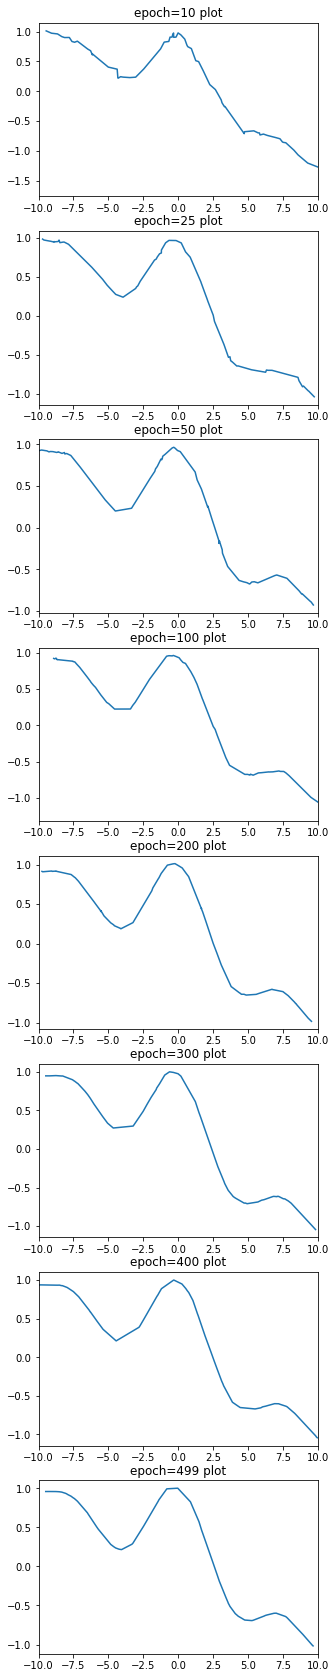

In [15]:
fig, axs = plt.subplots(8)
fig.set_size_inches(5, 30)
print('Графики по эпохам')

epoch_list = [10, 25, 50, 100, 200, 300, 400, 499]

for i, epoch in enumerate(gen_imgs_results):
        X_gen = epoch[:, 0].tolist()
        y_gen = epoch[:, 1].tolist()
        
        axs[i].set_xlim([-10, 10])
        axs[i].plot(X_gen, y_gen)
        axs[i].set_title(f"epoch={epoch_list[i]} plot")

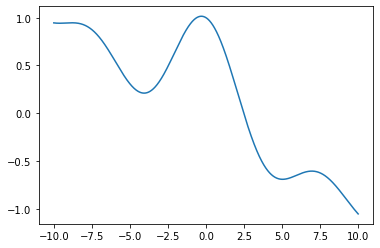

In [19]:
# Эталонный вариант
data = pd.DataFrame({'X': X_train, 'y': y_train, 'label': 1})

plt.plot(X_train, y_train)

### Задание 2
Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [3]:
n_epochs = 10
batch_size = 128
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 64
channels = 1

sample_interval = 100

img_shape = (channels, img_size, img_size)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_channels, out_channels, kernel_size, stride, padding, bias=False, normalize=False): #activation='relu
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 512, 4, 1, 0, normalize=True),
            *block(512, 256, 4, 2, 1, normalize=True),
            *block(256, 128, 4, 2, 1, normalize=True),
            *block(128, 64, 4, 2, 1, normalize=True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        #img = img.view(img.size(0), *img_shape)
        return img

In [5]:
print(Generator().to(device))

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_channels, out_channels, kernel_size, stride, padding, bias=False, normalize=False): 
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(channels, 64, 4, 2, 1, normalize=False),
            *block(64, 128, 4, 2, 1, normalize=True),
            *block(128, 256, 4, 2, 1, normalize=True),
            *block(256, 512, 4, 2, 1, normalize=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
  

    def forward(self, img):
        validity = self.model(img)

        return validity

In [7]:
print(Discriminator().to(device))

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [11]:
d_loss_history = []
g_loss_history = []

In [12]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 0/469] [D loss: 0.687445] [G loss: 0.816972]


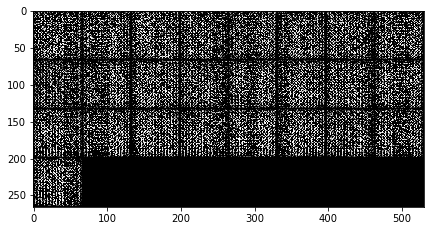

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 100/469] [D loss: 0.001344] [G loss: 6.186355]


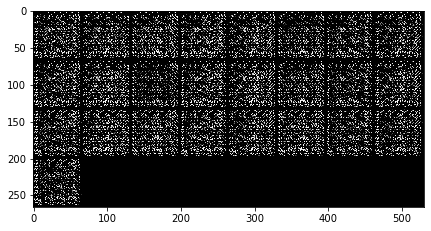

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 200/469] [D loss: 0.005605] [G loss: 8.293847]


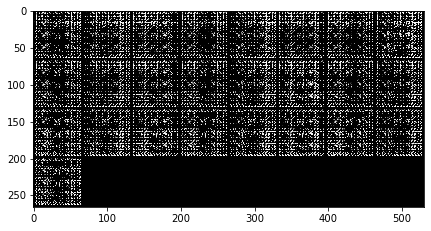

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 300/469] [D loss: 0.098648] [G loss: 6.254701]


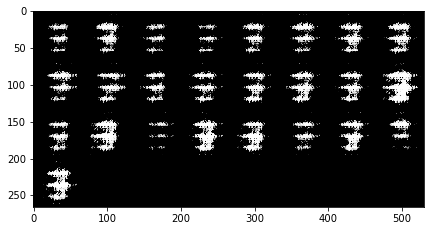

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 400/469] [D loss: 0.317513] [G loss: 2.033874]


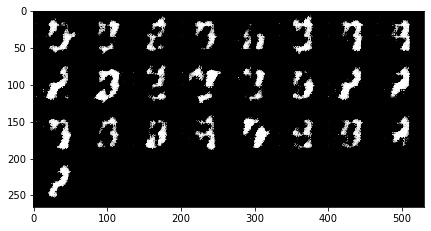

C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 31/469] [D loss: 0.197917] [G loss: 1.893299]


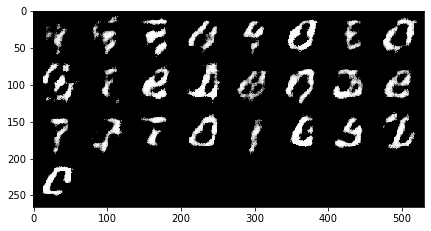

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 131/469] [D loss: 0.708424] [G loss: 0.342348]


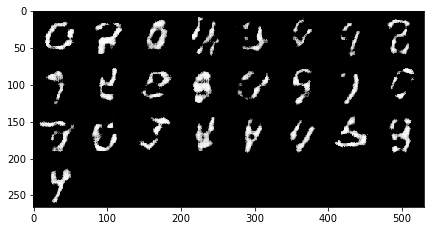

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 231/469] [D loss: 0.636610] [G loss: 4.201008]


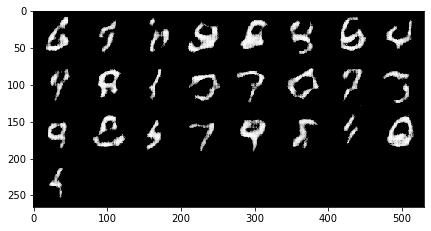

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 331/469] [D loss: 0.245302] [G loss: 1.691859]


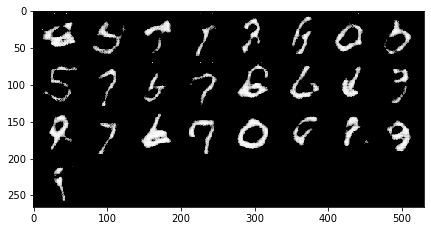

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 431/469] [D loss: 0.177922] [G loss: 3.525682]


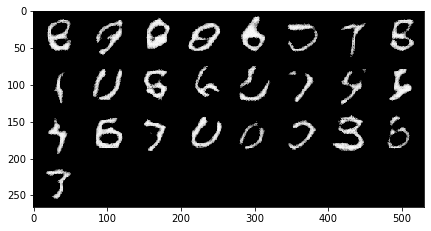

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 62/469] [D loss: 0.295588] [G loss: 1.851667]


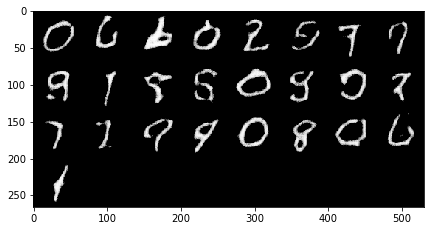

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 162/469] [D loss: 0.191969] [G loss: 1.586109]


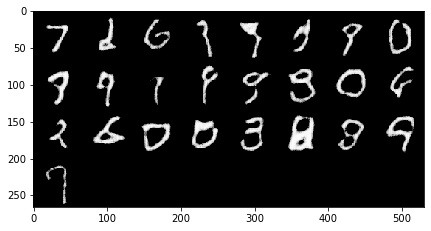

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 262/469] [D loss: 0.423176] [G loss: 0.890605]


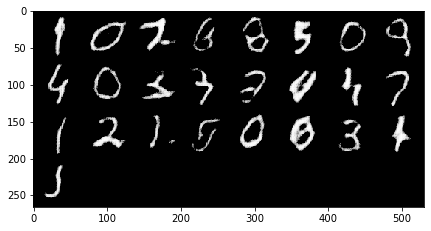

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 362/469] [D loss: 0.040493] [G loss: 3.369600]


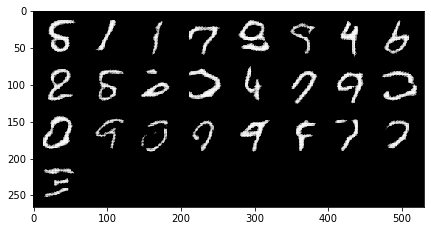

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 462/469] [D loss: 0.371895] [G loss: 1.078374]


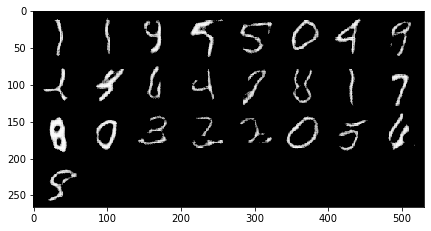

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 93/469] [D loss: 0.315706] [G loss: 1.097301]


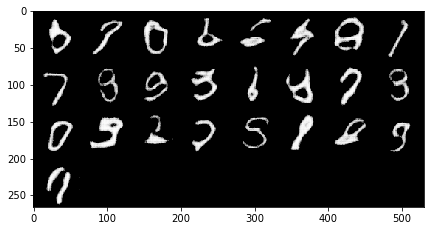

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 193/469] [D loss: 0.216413] [G loss: 3.144431]


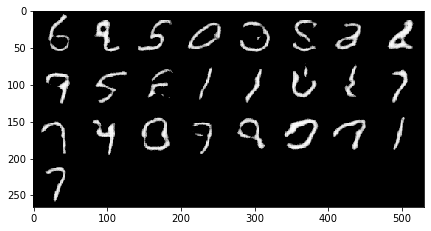

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 293/469] [D loss: 0.516200] [G loss: 0.646993]


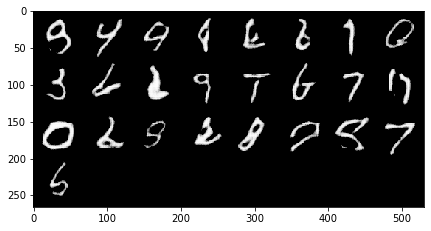

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 393/469] [D loss: 0.177722] [G loss: 3.323290]


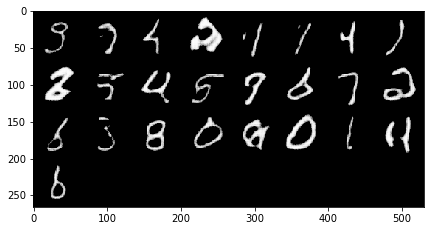

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 24/469] [D loss: 0.345522] [G loss: 0.961152]


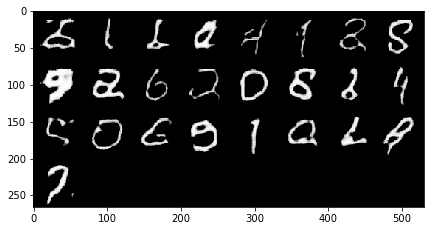

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 124/469] [D loss: 0.127614] [G loss: 2.295872]


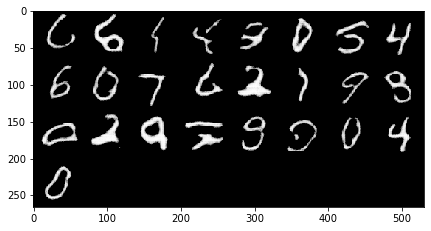

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 224/469] [D loss: 0.074404] [G loss: 2.555742]


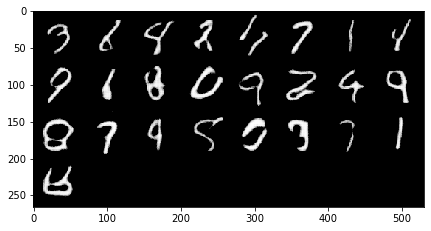

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 324/469] [D loss: 0.033849] [G loss: 3.918263]


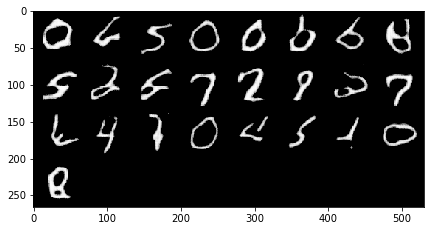

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 424/469] [D loss: 0.021523] [G loss: 4.398847]


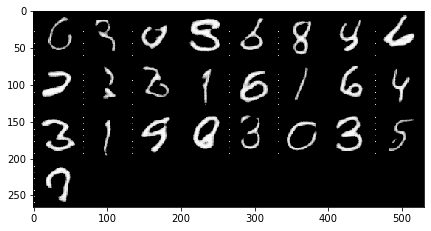

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 55/469] [D loss: 0.167761] [G loss: 3.330412]


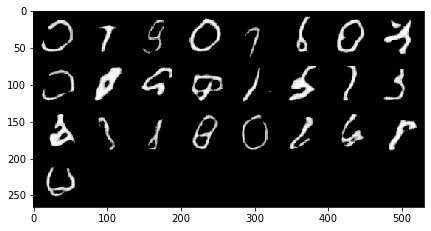

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 155/469] [D loss: 0.022471] [G loss: 4.055823]


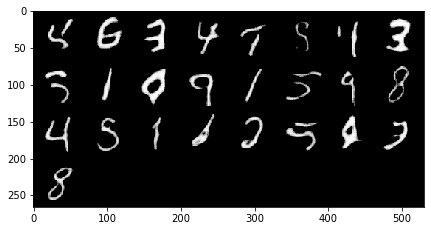

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 255/469] [D loss: 0.156228] [G loss: 1.946500]


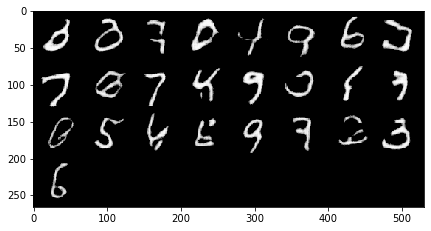

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 355/469] [D loss: 0.019335] [G loss: 4.440047]


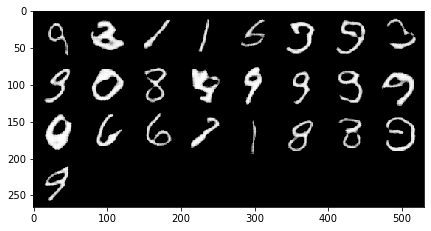

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 455/469] [D loss: 0.234838] [G loss: 2.011060]


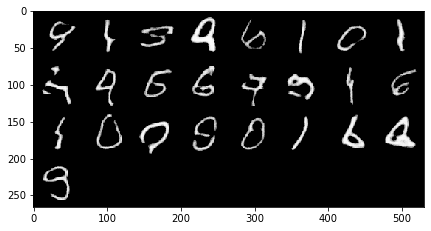

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 86/469] [D loss: 0.011175] [G loss: 4.676205]


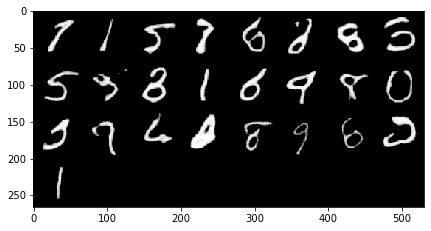

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 186/469] [D loss: 0.071645] [G loss: 4.216238]


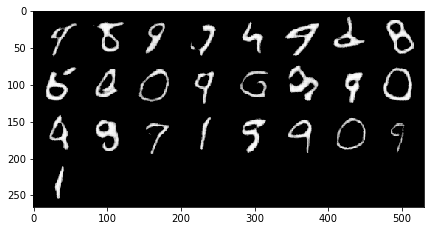

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 286/469] [D loss: 0.216871] [G loss: 2.006916]


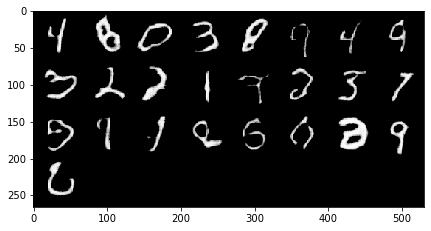

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 386/469] [D loss: 0.023622] [G loss: 4.580319]


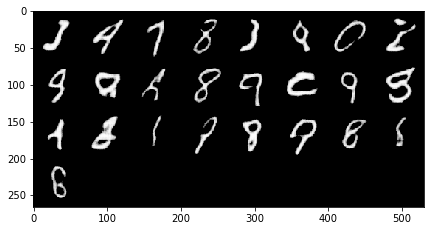

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 17/469] [D loss: 0.011191] [G loss: 4.807221]


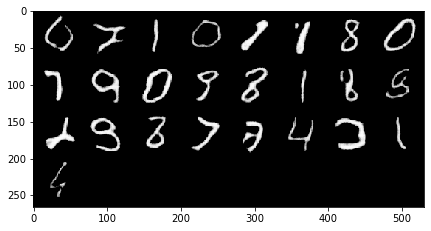

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 117/469] [D loss: 0.005437] [G loss: 5.880485]


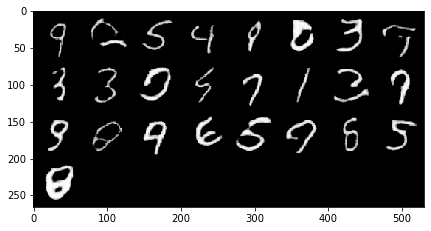

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 217/469] [D loss: 0.714566] [G loss: 2.109987]


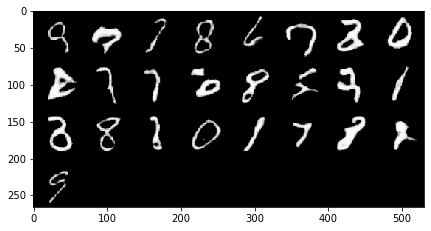

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 317/469] [D loss: 0.249128] [G loss: 2.251907]


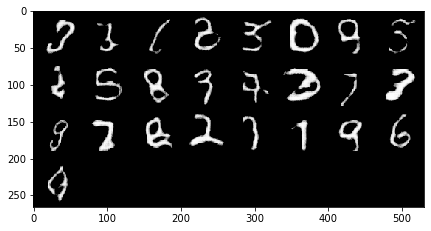

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 417/469] [D loss: 0.211404] [G loss: 2.338865]


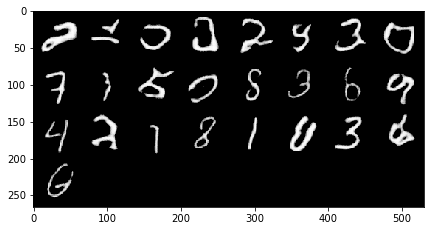

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 48/469] [D loss: 0.090343] [G loss: 3.541629]


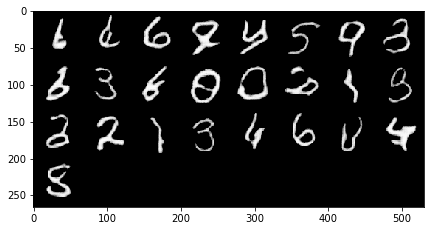

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 148/469] [D loss: 0.114019] [G loss: 3.313558]


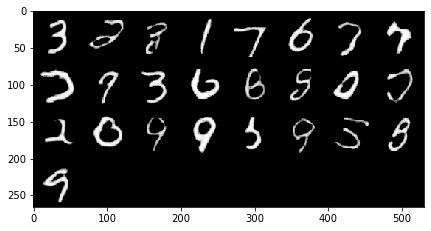

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 248/469] [D loss: 0.362864] [G loss: 3.613041]


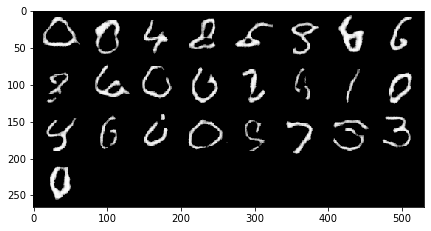

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 348/469] [D loss: 0.024614] [G loss: 4.167326]


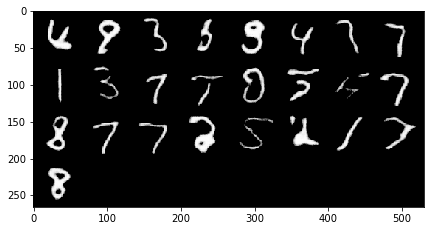

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 448/469] [D loss: 0.024560] [G loss: 6.013489]


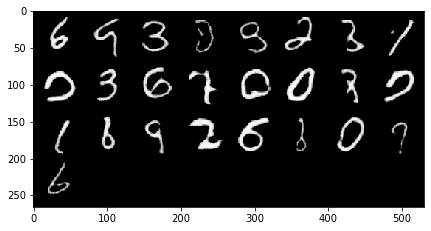

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 79/469] [D loss: 0.084020] [G loss: 4.914172]


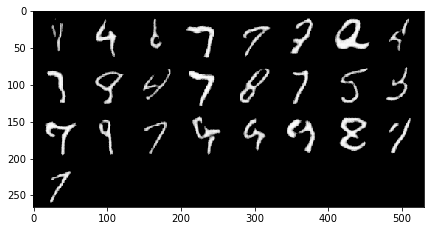

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 179/469] [D loss: 0.032951] [G loss: 3.424333]


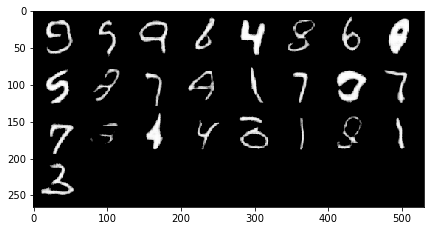

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 279/469] [D loss: 0.228907] [G loss: 3.013512]


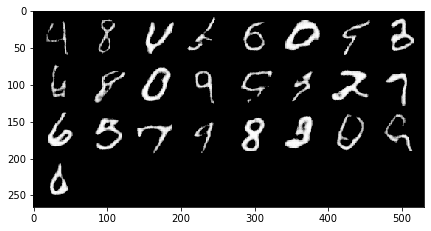

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 379/469] [D loss: 0.195835] [G loss: 1.705191]


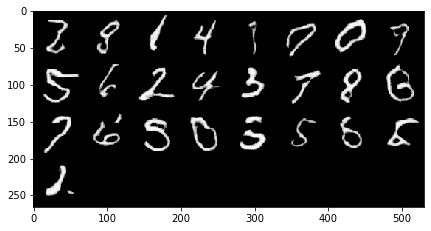

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

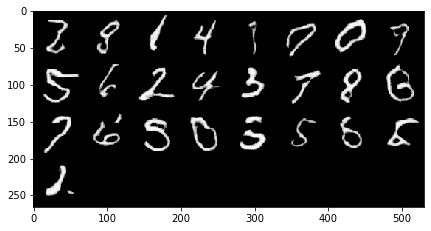

In [13]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.randn(batch_size, latent_dim, 1, 1)).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach()).view(-1)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            #display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())
